# Gaussian Process - A Brief Overview

In [1]:
%pylab inline

import numpy as np
import scipy.stats as stats
import pymc3 as pm
from theano import shared
from scipy import optimize

%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# Gaussian distribution

One of the most studied distribution, with lots of nice (i.e., easy for computation) properties.
$$p(x \mid \mu, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$
where $\mu$ is the mean vector and $\Sigma$ is the covariance matrix.

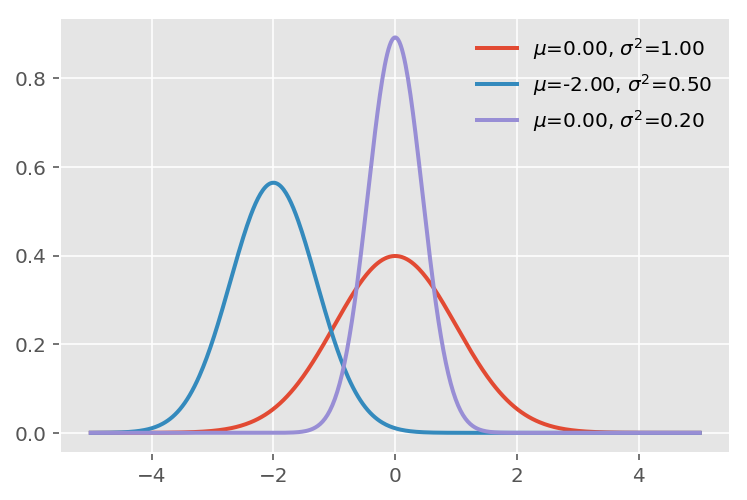

In [2]:
x = np.linspace(-5, 5, 500)
mu = [0, -2, 0]
sd = [1, .5, .2]
for mi, si in zip(mu, sd):
    rv = stats.norm(mi, np.sqrt(si))
    plot(x, rv.pdf(x), lw=2, label=('$\mu$=%.2f, $\sigma^2$=%.2f' %(mi,si)))
legend(loc='best', frameon=False);

A set of Gaussians are generally easy to work with. For example, sum of Gaussians is also Gaussian, and many distribution is actually generated by operation with Gaussian. Moreover, the marginal distribution of any subset of elements from  a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$


# Gaussian distribution with infinite dimension  

The following text is largely adapted from Chris Fonnesbeck's [GP_showdown](https://github.com/fonnesbeck/gp_showdown)

Gaussian process is a generalization of a multivariate Gaussian distribution to infinitely many variables. Informally, you can think of a infinitely long vector as a function, cause a function just takes continuous values and return some outputs. A Gaussian process is thus defined as an infinite collection of random variables, which any finite subset have a Gaussian distribution.

Moreover, having an infinite-dimensional Gaussian is not a problem when it is treated as a function. We can evaluated the function at the points where we have information.

For this reason, Gaussian process is often defined as ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean *function* and a covariance *function*:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

Using the marginalization property makes working with Gaussian process easy: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, a 1D GP:

$$ p(f(x))\sim \mathcal{GP}(m(x)=0, k(x,x^{\prime}) = \exp\left(-\frac{1}{2}(x-x^{\prime})^2\right)) $$

here, the covariance function is a **squared exponential**, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points. Focus on a finite subset of function values, and plot the coordinates of $f(x)$ as a function of the corresponding $x$ values: 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.


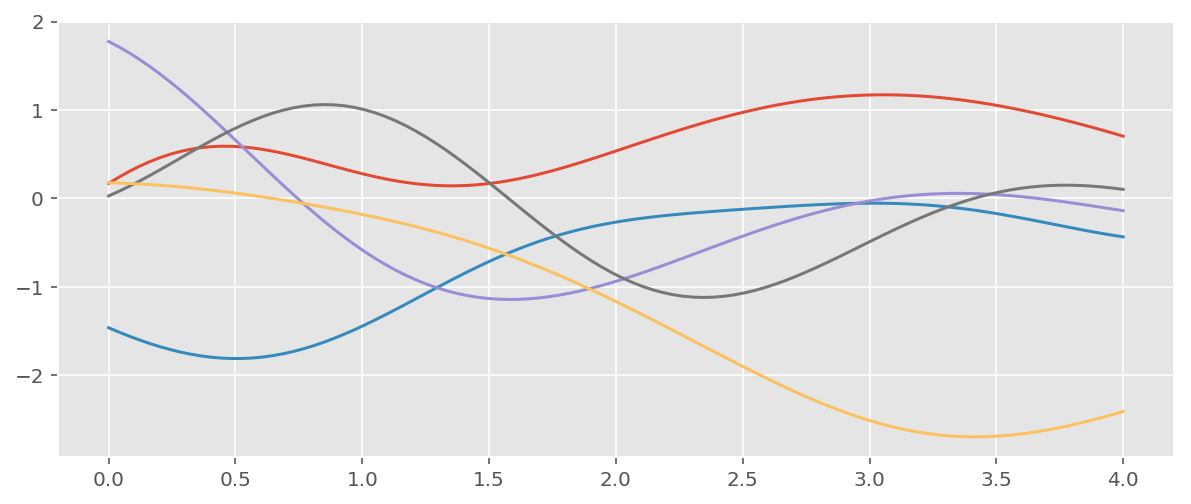

In [3]:
import theano
import theano.tensor as tt

np.random.seed(20170401)
n, n2 = 20, 100
Z = np.linspace(0, 4, n2)[:,None]

l_true, s2_f_true, s2_n_true = 1., 1., 0
with pm.Model() as model:
    # cov
    cov = pm.gp.cov.ExpQuad(1, l_true)
    # noise, epsilon
    K_noise = s2_n_true**2 * tt.eye(n2)
    
# evaluate the covariance with the given hyperparameters
K1 = theano.function([], cov(Z)+K_noise)()

# generate fake data from GP with white noise (with variance sigma2)
ymu = np.random.multivariate_normal(np.zeros(n2), K1, 5)

ax1 = plt.figure(figsize=(10,4))
plt.plot(Z, ymu.T, ms=10);

It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process. However, it could be shown that for example, squared exponential covariance function is equivalent to regression using infinitely many Gaussian shaped basis functions placed everywhere (not just at your training points). In fact, Gaussian Process was quite extensively studied in Machine Learning Community (it was called a Machine learning tool), and has quite a lot of connection with Deep learning and neural network. Quoting from Yarin Gal's [blog](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) that summarised this nicely: 
> Take a neural network (a recursive application of weighted linear functions followed by non-linear functions), put a probability distribution over each weight (a normal distribution for example), and with infinitely many weights you recover a Gaussian process (see [Neal](http://www.cs.toronto.edu/pub/radford/thesis.pdf) or [Williams](http://papers.nips.cc/paper/1197-computing-with-infinite-networks.pdf) for more details).

Most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

# Posterior prediction

It is not always easy to understand prediction in GP at the beginning, especially if you are used to think of $y=f(x, \lambda)$ and parameters $\lambda$ being estimated to return a tide bound function. With $\mathcal{N}(mu=0, \Sigma)$, it is not always immediately apparent how to generate posterior prediction from a zero mean Gaussian. However, prediction from Gaussian Process is conditioned on the input data:
$$ f_*|X_*, X, f \sim \mathcal{N}(K(X_*, X)K(X, X)^{-1}f, K(X_*, X_*)-K(X_*, X)K(X, X)^{-1}K(X, X_*))$$

For example, given the below observation:

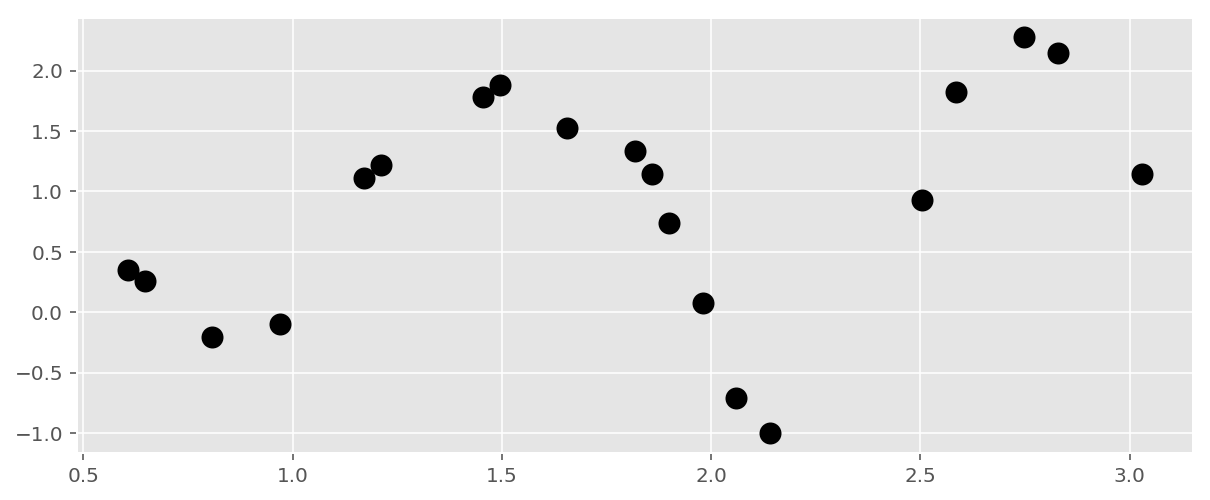

In [16]:
X = np.random.choice(Z[(Z>.5)*(Z<3.5)], n)[:, None]

l_true, s2_f_true, s2_n_true = .3, 1., .1
with pm.Model() as model:
    # cov
    cov = pm.gp.cov.ExpQuad(1, l_true)
    # noise, epsilon
    K_noise = s2_n_true**2 * tt.eye(n)
    
# evaluate the covariance with the given hyperparameters
K1 = theano.function([], cov(X)+K_noise)()

# generate fake data from GP with white noise (with variance sigma2)
ymu = np.random.multivariate_normal(np.zeros(n), K1)

ax1 = plt.figure(figsize=(10,4))
plt.plot(X, ymu, 'ok', ms=10);

We can make prediction on the points that are not been observed. In effect, this is generating from the conditional pdf.

In [17]:
from theano.tensor.slinalg import solve_lower_triangular as solve_lt
from theano.tensor.slinalg import solve_upper_triangular as solve_ut
from theano.tensor.slinalg import cholesky
from theano.tensor.nlinalg import matrix_inverse
S_xz = cov(X,Z)
S_zz = cov(Z)
K = cov(X) + K_noise
L = tt.slinalg.cholesky(K)
alpha = solve_ut(L.T, solve_lt(L, ymu))
S_xz = cov(X,Z)
m_post = theano.function([], tt.dot(S_xz.T, alpha))()
v = solve_lt(L, S_xz)
S_post = theano.function([], S_zz - tt.dot(v.T, v))()
# S_chol = theano.function([], cholesky(S_zz - tt.dot(v.T, v)))()

# Using Matrix inverse, slower
# S_inv = matrix_inverse(cov(X) + K_noise)
# m_post = theano.function([], tt.dot(tt.dot(S_xz.T, S_inv), ymu))()
# S_post = theano.function([], S_zz - tt.dot(tt.dot(S_xz.T, S_inv), S_xz))()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


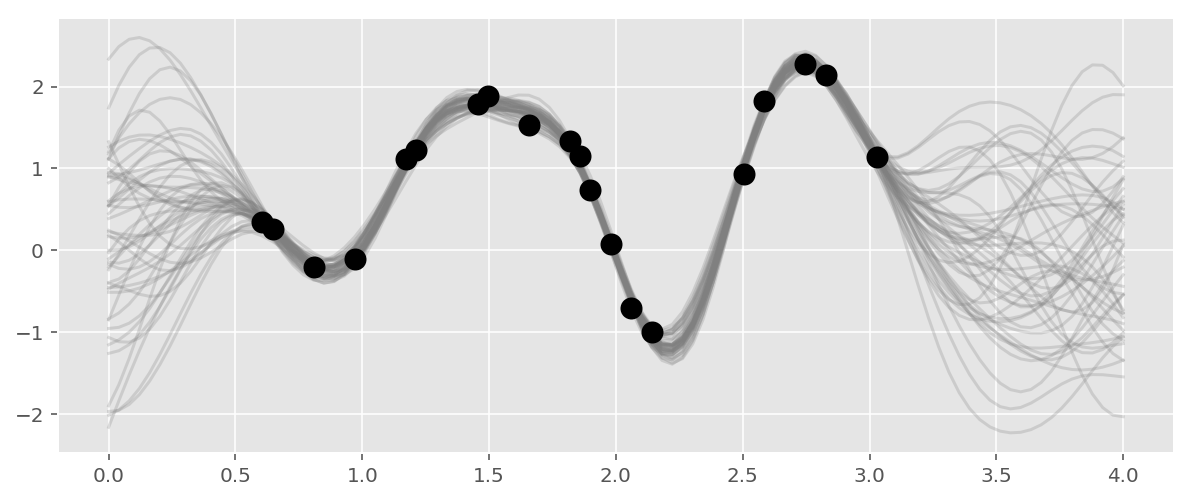

In [18]:
# generate fake data from GP with white noise (with variance sigma2)
ystim = np.random.multivariate_normal(m_post, S_post, 50)

ax1 = plt.figure(figsize=(10,4))
plt.plot(Z, ystim.T, c='gray',alpha=.25, ms=10)
plt.plot(X, ymu, 'ok', ms=10);

# Parameter estimation (Gaussian Likelihood)

In [19]:
with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.HalfCauchy('l', beta=3) 
    
    # prior on the function variance
    s2_f = pm.HalfCauchy('s2_f', beta=2)
    
    # prior on the noise variance
    s2_n = pm.HalfCauchy('s2_n', beta=2)
    
    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)

    intercept = pm.Cauchy('b',alpha=0,beta=10)
    meanfuc = pm.gp.mean.Constant(intercept)
    
    Sigma = f_cov(X) + tt.eye(n)*s2_n**2
    
    # y_obs = pm.MvNormal('y_obs', mu=meanfuc(X).squeeze(), cov=Sigma, observed=ymu)
    y_obs = pm.gp.GP('y_obs', 
                     mean_func=meanfuc, 
                     cov_func=f_cov, 
                     sigma=s2_n,
                     X=X,
                     observed=ymu,
                     total_size=n)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -156.21:  30%|███       | 60154/200000 [00:50<01:34, 1476.23it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -156.2

100%|██████████| 2000/2000 [00:42<00:00, 47.33it/s] 


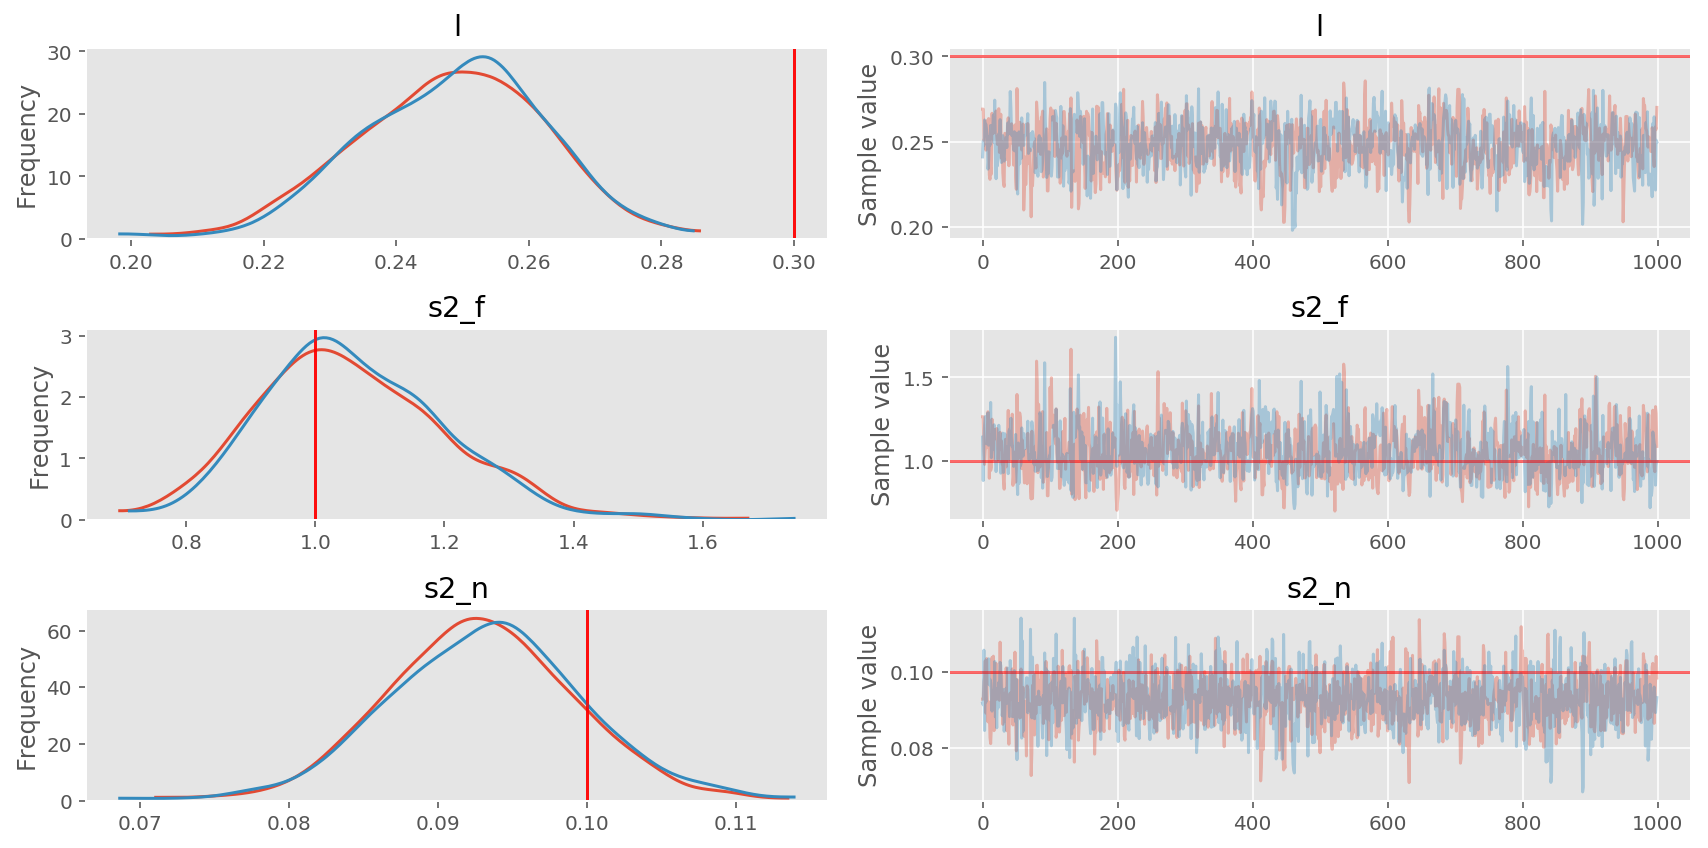

In [20]:
with model:
    trace = pm.sample(2000, njobs=2, tune=1000)
temp_trace = trace[1000:]

pm.traceplot(temp_trace, varnames=['l', 's2_f', 's2_n'],
             lines={"l": l_true,
                    "s2_f": s2_f_true,
                    "s2_n": s2_n_true});

The PyMC3 MvNormal distribution is recently under some changes, using the older implementation below.

In [21]:
from pymc3.distributions.distribution import Continuous,draw_values,generate_samples
from scipy import stats
def get_tau_cov(mu, tau=None, cov=None):
    """
    Find precision and standard deviation
    .. math::
        \Tau = \Sigma^-1
    Parameters
    ----------
    mu : array-like
    tau : array-like, not required if cov is passed
    cov : array-like, not required if tau is passed
    Results
    -------
    Returns tuple (tau, sd)
    Notes
    -----
    If neither tau nor cov is provided, returns an identity matrix.
    """
    if tau is None:
        if cov is None:
            raise ValueError('Incompatible parameterization. Either use tau'
                             'or cov to specify distribution.')
        else:
            tau = tt.nlinalg.matrix_inverse(cov)

    else:
        if cov is not None:
            raise ValueError("Can't pass both tau and sd")
        else:
            cov = tt.nlinalg.matrix_inverse(tau)

    return (tau, cov)

class MvNormal(Continuous):
    R"""
    Multivariate normal log-likelihood.
    .. math::
       f(x \mid \pi, T) =
           \frac{|T|^{1/2}}{(2\pi)^{1/2}}
           \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime} T (x-\mu) \right\}
    ========  ==========================
    Support   :math:`x \in \mathbb{R}^k`
    Mean      :math:`\mu`
    Variance  :math:`T^{-1}`
    ========  ==========================
    Parameters
    ----------
    mu : array
        Vector of means.
    cov : array
        Covariance matrix. Not required if tau is passed.
    tau : array
        Precision matrix. Not required if tau is passed.
    Flags
    ----------
    gpu_compat : False, because LogDet is not GPU compatible yet.
                 If this is set as true, the GPU compatible (but numerically unstable) log(det) is used.
    """

    def __init__(self, mu, cov=None, tau=None, gpu_compat=False, *args, **kwargs):
        super(MvNormal, self).__init__(*args, **kwargs)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(mu)
        tau, cov = get_tau_cov(mu, tau=tau, cov=cov)
        self.tau = tt.as_tensor_variable(tau)
        self.cov = tt.as_tensor_variable(cov)
        self.gpu_compat = gpu_compat
        if gpu_compat is False and theano.config.device == 'gpu':
            warnings.warn("The function used is not GPU compatible. Please check the gpu_compat flag")

    def random(self, point=None, size=None):
        mu, cov = draw_values([self.mu, self.cov], point=point)

        def _random(mean, cov, size=None):
            return stats.multivariate_normal.rvs(
                mean, cov, None if size == mean.shape else size)

        samples = generate_samples(_random,
                                   mean=mu, cov=cov,
                                   dist_shape=self.shape,
                                   broadcast_shape=mu.shape,
                                   size=size)
        return samples

    def logp(self, value):
        mu = self.mu
        tau = self.tau

        delta = value - mu
        k = tau.shape[0]

        result = k * tt.log(2 * np.pi)
        if self.gpu_compat:
            result -= tt.log(det(tau))
        else:
            result -= logdet(tau)
        result += (tt.dot(delta, tau) * delta).sum(axis=delta.ndim - 1)
        return -1 / 2. * result

from pymc3.model import modelcontext
from theano.tensor.nlinalg import matrix_inverse
def sample_gp(trace, K, sigma, X_values, samples=None, obs_noise=True, model=None, 
              random_seed=None, progressbar=True):
    """Generate samples from a posterior Gaussian process.
    Parameters
    ----------
    trace : backend, list, or MultiTrace
        Trace generated from MCMC sampling.
    gp : Gaussian process object
        The GP variable to sample from.
    X_values : array
        Grid of values at which to sample GP.
    samples : int
        Number of posterior predictive samples to generate. Defaults to the
        length of `trace`
    obs_noise : bool
        Flag for including observation noise in sample. Defaults to True.
    model : Model 
        Model used to generate `trace`. Optional if in `with` context manager.
    random_seed : integer > 0
        Random number seed for sampling.
    progressbar : bool
        Flag for showing progress bar.
    
    Returns
    -------
    Array of samples from posterior GP evaluated at Z.
    """
    model = modelcontext(model)
    
    if samples is None:
        samples = len(trace)
    
    if random_seed:
        np.random.seed(random_seed)
    
    if progressbar:
        indices = tqdm(np.random.randint(0, len(trace), samples), total=samples)
    else:
        indices = np.random.randint(0, len(trace), samples)

    X = X_values['X']
    Y = X_values['Y']
    Z = X_values['Z']
    
    S_xz = K(X, Z)
    S_zz = K(Z)
    if obs_noise:
        S_inv = matrix_inverse(K(X) + tt.eye(X.shape[0])*sigma**2)
    else:
        S_inv = matrix_inverse(K(X))

    # Posterior mean
    m_post = tt.dot(tt.dot(S_xz.T, S_inv), Y)
    # Posterior covariance
    S_post = S_zz - tt.dot(tt.dot(S_xz.T, S_inv), S_xz)
    gp_post = MvNormal.dist(m_post, cov=S_post, shape=Z.shape[0])
    
    # S_post_chol = qr_chol(S_post)
    # gp_post = pm.MvNormal.dist(m_post, chol=S_post_chol, shape=Z.shape[0])
    
    samples = [gp_post.random(point=trace[idx]) for idx in indices]
    
    return np.array(samples)

/usr/local/lib/python3.5/dist-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


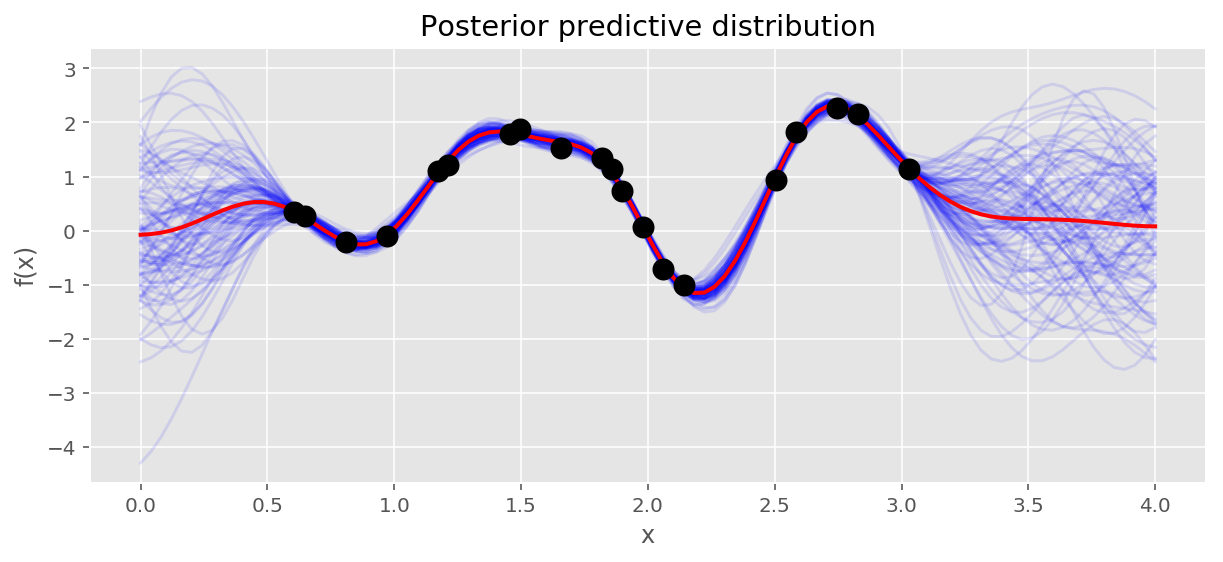

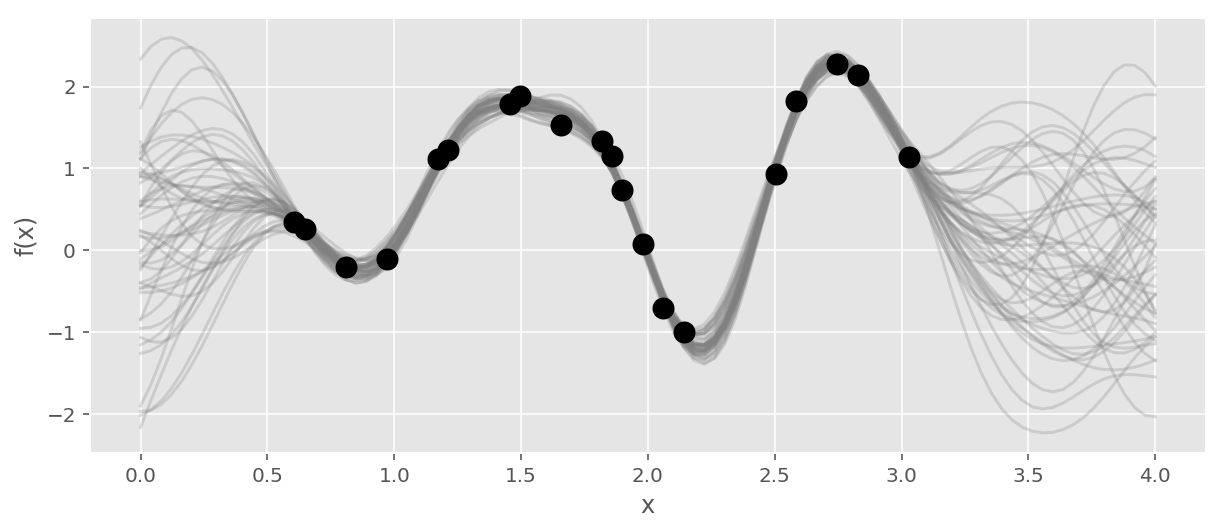

In [22]:
nsample = 100
X_values = {'X':X, 'Y':ymu, 'Z':Z}
with model:
    gp_samples = sample_gp(temp_trace, f_cov, s2_n, X_values, obs_noise=True, 
                           samples=nsample, progressbar=None)
#     gp_samples = pm.gp.sample_gp(temp_trace, y_obs, Z, 
#                                  samples=nsample, progressbar=None)

_, ax = plt.subplots(figsize=(10,4))

[ax.plot(Z, x, color='b', alpha=0.1) for x in gp_samples]
meanline = np.mean(gp_samples, 0)
line, = ax.plot(Z.squeeze(), meanline,color='r', lw=2)

# overlay the observed data
ax.plot(X, ymu, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");

_, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(Z, ystim.T, c='gray',alpha=.25, ms=10)
ax1.plot(X, ymu, 'ok', ms=10)
ax1.set_xlabel("x");
ax1.set_ylabel("f(x)");

# Parameter estimation (Non-Gaussian Likelihood)

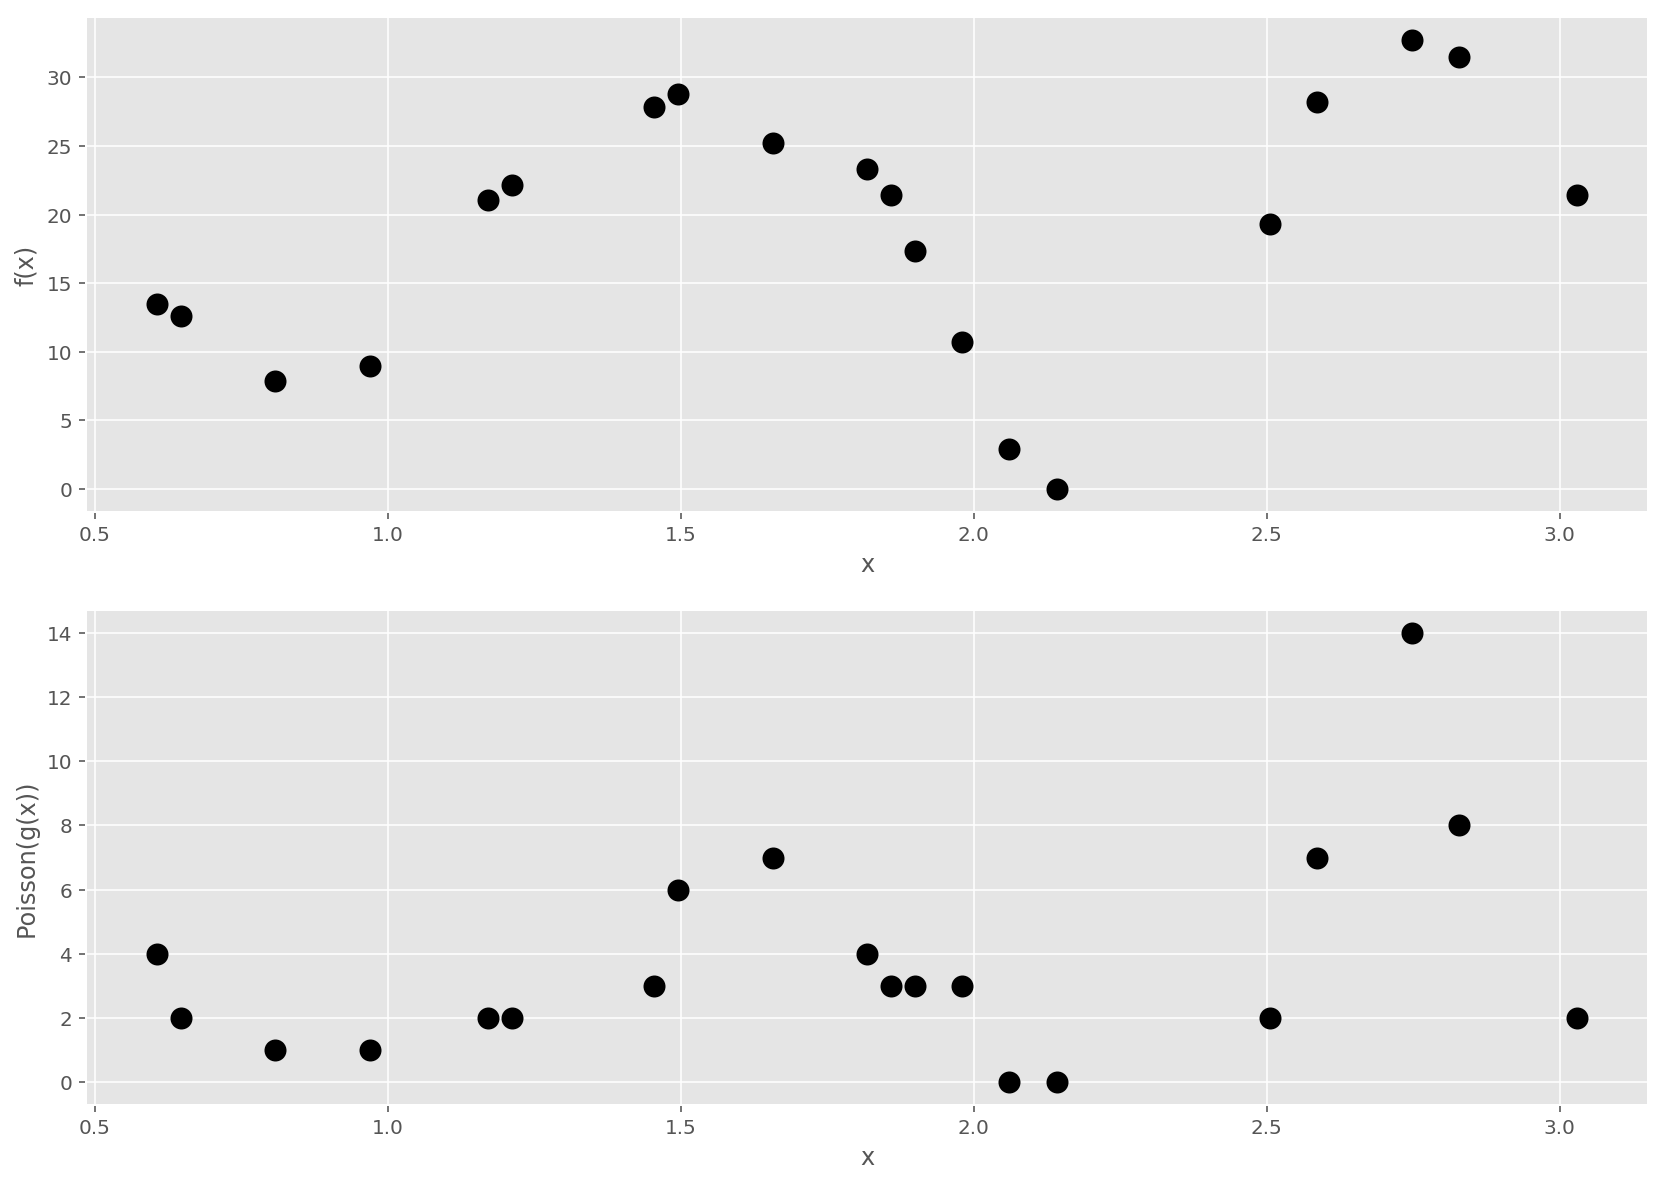

In [73]:
ymu1 = (ymu - ymu.min())*10
y = np.random.poisson(np.exp(ymu))

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(211)
ax1.plot(X, ymu1, 'ok', ms=10)
ax1.set_xlabel("x")
ax1.set_ylabel("f(x)")

ax1 = fig.add_subplot(212)
ax1.plot(X, y, 'ok', ms=10)
ax1.set_xlabel("x")
ax1.set_ylabel("Poisson(g(x))")

plt.show()

In [75]:
with pm.Model() as model_ng:
    # priors on the covariance function hyperparameters
    l = pm.HalfCauchy('l', beta=3) 
    
    # prior on the function variance
    s2_f = pm.HalfCauchy('s2_f', beta=2)
    
    # prior on the noise variance
    s2_n = pm.HalfCauchy('s2_n', beta=2)
    
    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(1, l)

    intercept = pm.Cauchy('b',alpha=0,beta=10)
    
    Sigma = f_cov(X) + tt.eye(n)*s2_n**2
    y_mu = pm.MvNormal('y_mu', mu=intercept, cov=Sigma, shape=(n,1))
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(y_mu), observed=y)

    trace = pm.sample(2000, njobs=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
 10%|▉         | 19365/200000 [00:20<02:59, 1004.17it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -1,253.5

 34%|███▍      | 684/2000 [00:52<01:09, 18.85it/s]


JoblibLinAlgError: JoblibLinAlgError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7fbeabb4c9c0, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fbeabb4c9c0, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with pm.Model() as model_ng:\n    # priors on the...\n\n    trace = pm.sample(2000, njobs=2, tune=1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 4, 18, 17, 8, 3, 14009, tzinfo=datetime.timezone.utc), 'msg_id': '35BAAE7B0AAD4B7DA9EF15B4343AB92A', 'msg_type': 'execute_request', 'session': '668E6A82BE4F47E89778495B9987C295', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '35BAAE7B0AAD4B7DA9EF15B4343AB92A', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.warn("Unknown message type: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'668E6A82BE4F47E89778495B9987C295']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'with pm.Model() as model_ng:\n    # priors on the...\n\n    trace = pm.sample(2000, njobs=2, tune=1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 4, 18, 17, 8, 3, 14009, tzinfo=datetime.timezone.utc), 'msg_id': '35BAAE7B0AAD4B7DA9EF15B4343AB92A', 'msg_type': 'execute_request', 'session': '668E6A82BE4F47E89778495B9987C295', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '35BAAE7B0AAD4B7DA9EF15B4343AB92A', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'668E6A82BE4F47E89778495B9987C295'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with pm.Model() as model_ng:\n    # priors on the...\n\n    trace = pm.sample(2000, njobs=2, tune=1000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 4, 18, 17, 8, 3, 14009, tzinfo=datetime.timezone.utc), 'msg_id': '35BAAE7B0AAD4B7DA9EF15B4343AB92A', 'msg_type': 'execute_request', 'session': '668E6A82BE4F47E89778495B9987C295', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '35BAAE7B0AAD4B7DA9EF15B4343AB92A', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='with pm.Model() as model_ng:\n    # priors on the...\n\n    trace = pm.sample(2000, njobs=2, tune=1000)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'with pm.Model() as model_ng:\n    # priors on the...\n\n    trace = pm.sample(2000, njobs=2, tune=1000)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('with pm.Model() as model_ng:\n    # priors on the...\n\n    trace = pm.sample(2000, njobs=2, tune=1000)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('with pm.Model() as model_ng:\n    # priors on the...\n\n    trace = pm.sample(2000, njobs=2, tune=1000)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='with pm.Model() as model_ng:\n    # priors on the...\n\n    trace = pm.sample(2000, njobs=2, tune=1000)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-75-9a36f40c6f53>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fbe544fec88, executi..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fbe14f280c0, file "<ipython-input-75-9a36f40c6f53>", line 1>
        result = <ExecutionResult object at 7fbe544fec88, executi..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fbe14f280c0, file "<ipython-input-75-9a36f40c6f53>", line 1>, result=<ExecutionResult object at 7fbe544fec88, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fbe14f280c0, file "<ipython-input-75-9a36f40c6f53>", line 1>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/laoj/Documents/Github/Bayesian_Smoothing_EyeMovement/<ipython-input-75-9a36f40c6f53> in <module>()
     15     
     16     Sigma = f_cov(X) + tt.eye(n)*s2_n**2
     17     y_mu = pm.MvNormal('y_mu', mu=intercept, cov=Sigma, shape=(n,1))
     18     y_obs = pm.Poisson('y_obs', mu=pm.math.exp(y_mu), observed=y)
     19 
---> 20     trace = pm.sample(2000, njobs=2, tune=1000)

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/sampling.py in sample(draws=2000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='advi', n_init=200000, start=<MultiTrace: 1 chains, 2 iterations, 8 variables>, trace=None, chain=0, njobs=2, tune=1000, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=-1, live_plot=False, **kwargs={})
    257         sample_func = _mp_sample
    258         sample_args['njobs'] = njobs
    259     else:
    260         sample_func = _sample
    261 
--> 262     return sample_func(**sample_args)
        sample_func = <function _mp_sample>
        sample_args = {'chain': 0, 'draws': 2000, 'live_plot': False, 'model': <pymc3.model.Model object>, 'njobs': 2, 'progressbar': True, 'random_seed': -1, 'start': <MultiTrace: 1 chains, 2 iterations, 8 variables>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, ...}
    263 
    264 
    265 def _sample(draws, step=None, start=None, trace=None, chain=0, tune=None,
    266             progressbar=True, model=None, random_seed=-1, live_plot=False,

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 2000, 'live_plot': False, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000})
    444     pbars = [kwargs.pop('progressbar')] + [False] * (njobs - 1)
    445     traces = Parallel(n_jobs=njobs)(delayed(_sample)(chain=chains[i],
    446                                                      progressbar=pbars[i],
    447                                                      random_seed=rseed[i],
    448                                                      start=start_vals[i],
--> 449                                                      **kwargs) for i in range(njobs))
        kwargs = {'draws': 2000, 'live_plot': False, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000}
        njobs = 2
    450     return merge_traces(traces)
    451 
    452 
    453 def stop_tuning(step):

...........................................................................
/usr/local/lib/python3.5/dist-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
LinAlgError                                        Tue Apr 18 19:09:25 2017
PID: 1155                                    Python 3.5.2: /usr/bin/python3
...........................................................................
/usr/local/lib/python3.5/dist-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (), {'chain': 0, 'draws': 2000, 'live_plot': False, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 548415572, 'start': {'b': 0.9946309590548098, 'l': 94.354142523106688, 'l_log_': 4.547055176766003, 's2_f': 0.47478627711404309, 's2_f_log_': -0.74489051911998816, 's2_n': 0.10180844345620345, 's2_n_log_': -2.2846622366921796, 'y_mu': array([[ 1.30013213],
       [ 1.18706078],
    ...83],
       [ 1.39001932],
       [ 1.36041573]])}, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = ()
        kwargs = {'chain': 0, 'draws': 2000, 'live_plot': False, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 548415572, 'start': {'b': 0.9946309590548098, 'l': 94.354142523106688, 'l_log_': 4.547055176766003, 's2_f': 0.47478627711404309, 's2_f_log_': -0.74489051911998816, 's2_n': 0.10180844345620345, 's2_n_log_': -2.2846622366921796, 'y_mu': array([[ 1.30013213],
       [ 1.18706078],
    ...83],
       [ 1.39001932],
       [ 1.36041573]])}, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 1000}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/sampling.py in _sample(draws=2000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'b': 0.9946309590548098, 'l': 94.354142523106688, 'l_log_': 4.547055176766003, 's2_f': 0.47478627711404309, 's2_f_log_': -0.74489051911998816, 's2_n': 0.10180844345620345, 's2_n_log_': -2.2846622366921796, 'y_mu': array([[ 1.30013213],
       [ 1.18706078],
    ...83],
       [ 1.39001932],
       [ 1.36041573]])}, trace=None, chain=0, tune=1000, progressbar=True, model=<pymc3.model.Model object>, random_seed=548415572, live_plot=False, **kwargs={})
    272                             tune, model, random_seed)
    273     if progressbar:
    274         sampling = tqdm(sampling, total=draws)
    275     try:
    276         strace = None
--> 277         for it, strace in enumerate(sampling):
        it = 684
        strace = <pymc3.backends.ndarray.NDArray object>
        sampling =  34%|███▍      | 684/2000 [00:52<01:40, 13.12it/s]
    278             if live_plot:
    279                 if it >= skip_first:
    280                     trace = MultiTrace([strace])
    281                     if it == skip_first:

...........................................................................
/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py in __iter__(self= 34%|███▍      | 684/2000 [00:52<01:40, 13.12it/s])
    828             except AttributeError:
    829                 raise TqdmDeprecationWarning("""\
    830 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    831 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    832 
--> 833             for obj in iterable:
        obj = <pymc3.backends.ndarray.NDArray object>
        iterable = <generator object _iter_sample>
    834                 yield obj
    835                 # Update and print the progressbar.
    836                 # Note: does not call self.update(1) for speed optimisation.
    837                 n += 1

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/sampling.py in _iter_sample(draws=2000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'b': 0.9946309590548098, 'l': 94.354142523106688, 'l_log_': 4.547055176766003, 's2_f': 0.47478627711404309, 's2_f_log_': -0.74489051911998816, 's2_n': 0.10180844345620345, 's2_n_log_': -2.2846622366921796, 'y_mu': array([[ 1.30013213],
       [ 1.18706078],
    ...83],
       [ 1.39001932],
       [ 1.36041573]])}, trace=None, chain=0, tune=1000, model=<pymc3.model.Model object>, random_seed=548415572)
    371     try:
    372         for i in range(draws):
    373             if i == tune:
    374                 step = stop_tuning(step)
    375             if step.generates_stats:
--> 376                 point, states = step.step(point)
        point = {'b': array(1.3283579633038896), 'l_log_': array(1.0654725095141704), 's2_f_log_': array(-2.3499128752428633), 's2_n_log_': array(-3.2561179591048495), 'y_mu': array([[ 1.26471414],
       [ 1.32641484],
    ...36],
       [ 1.30147142],
       [ 1.22212733]])}
        states = [{'depth': 4, 'diverging': False, 'energy': array(1063.7997174074462), 'energy_error': -0.67234342884944454, 'max_energy_error': 0.74619960008817543, 'mean_tree_accept': 0.89135846356381687, 'step_size': 0.32687667699884126, 'step_size_bar': 0.21935601422535972, 'tree_size': 15, 'tune': True}]
        step.step = <bound method ArrayStepShared.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    377                 if strace.supports_sampler_stats:
    378                     strace.record(point, states)
    379                 else:
    380                     strace.record(point)

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'b': array(1.3283579633038896), 'l_log_': array(1.0654725095141704), 's2_f_log_': array(-2.3499128752428633), 's2_n_log_': array(-3.2561179591048495), 'y_mu': array([[ 1.26471414],
       [ 1.32641484],
    ...36],
       [ 1.30147142],
       [ 1.22212733]])})
    146             share.container.storage[0] = point[var]
    147 
    148         bij = DictToArrayBijection(self.ordering, point)
    149 
    150         if self.generates_stats:
--> 151             apoint, stats = self.astep(bij.map(point))
        apoint = undefined
        stats = undefined
        self.astep = <bound method NUTS.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        bij.map = <bound method DictToArrayBijection.map of <pymc3.blocking.DictToArrayBijection object>>
        point = {'b': array(1.3283579633038896), 'l_log_': array(1.0654725095141704), 's2_f_log_': array(-2.3499128752428633), 's2_n_log_': array(-3.2561179591048495), 'y_mu': array([[ 1.26471414],
       [ 1.32641484],
    ...36],
       [ 1.30147142],
       [ 1.22212733]])}
    152             return bij.rmap(apoint), stats
    153         else:
    154             apoint = self.astep(bij.map(point))
    155             return bij.rmap(apoint)

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([ 1.26471414,  1.32641484,  1.26247184,  1...32835796, -3.25611796, -2.34991288,  1.06547251]))
    172         start = Edge(q0, p0, v0, self.dlogp(q0), start_energy)
    173         tree = Tree(len(p0), self.leapfrog, start, step_size, self.Emax)
    174 
    175         for _ in range(self.max_treedepth):
    176             direction = logbern(np.log(0.5)) * 2 - 1
--> 177             diverging, turning = tree.extend(direction)
        diverging = False
        turning = False
        tree.extend = <bound method Tree.extend of <pymc3.step_methods.hmc.nuts.Tree object>>
        direction = 1
    178             q = tree.proposal.q
    179 
    180             if diverging or turning:
    181                 break

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py in extend(self=<pymc3.step_methods.hmc.nuts.Tree object>, direction=1)
    323         the tree extension was stopped because the termination criterior
    324         was reached (the trajectory is turning back).
    325         """
    326         if direction > 0:
    327             tree, diverging, turning = self._build_subtree(
--> 328                 self.right, self.depth, floatX(np.asarray(self.step_size)))
        self.right = Edge(q=array([ 1.25962203,  1.25481282,  1.31526... -0.10124878]), energy=array(1074.3089080734119))
        self.depth = 3
        self.step_size = 0.35046833370852831
    329             self.right = tree.right
    330         else:
    331             tree, diverging, turning = self._build_subtree(
    332                 self.left, self.depth, floatX(np.asarray(-self.step_size)))

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py in _build_subtree(self=<pymc3.step_methods.hmc.nuts.Tree object>, left=Edge(q=array([ 1.25962203,  1.25481282,  1.31526... -0.10124878]), energy=array(1074.3089080734119)), depth=3, epsilon=array(0.3504683337085283))
    369 
    370             proposal = Proposal(right.q, right.energy, p_accept)
    371             tree = Subtree(right, right, right.p, proposal, log_size, p_accept, 1)
    372             return tree, diverging, False
    373 
--> 374         tree1, diverging, turning = self._build_subtree(left, depth - 1, epsilon)
        tree1 = undefined
        diverging = undefined
        turning = undefined
        self._build_subtree = <bound method Tree._build_subtree of <pymc3.step_methods.hmc.nuts.Tree object>>
        left = Edge(q=array([ 1.25962203,  1.25481282,  1.31526... -0.10124878]), energy=array(1074.3089080734119))
        depth = 3
        epsilon = array(0.3504683337085283)
    375         if diverging or turning:
    376             return tree1, diverging, turning
    377 
    378         tree2, diverging, turning = self._build_subtree(tree1.right, depth - 1, epsilon)

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py in _build_subtree(self=<pymc3.step_methods.hmc.nuts.Tree object>, left=Edge(q=array([ 1.25962203,  1.25481282,  1.31526... -0.10124878]), energy=array(1074.3089080734119)), depth=2, epsilon=array(0.3504683337085283))
    373 
    374         tree1, diverging, turning = self._build_subtree(left, depth - 1, epsilon)
    375         if diverging or turning:
    376             return tree1, diverging, turning
    377 
--> 378         tree2, diverging, turning = self._build_subtree(tree1.right, depth - 1, epsilon)
        tree2 = undefined
        diverging = False
        turning = False
        self._build_subtree = <bound method Tree._build_subtree of <pymc3.step_methods.hmc.nuts.Tree object>>
        tree1.right = Edge(q=array([ 1.36373176,  1.26403004,  1.28988...  1.92514296]), energy=array(1767.5624388708309))
        depth = 2
        epsilon = array(0.3504683337085283)
    379 
    380         left, right = tree1.left, tree2.right
    381 
    382         if not (diverging or turning):

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py in _build_subtree(self=<pymc3.step_methods.hmc.nuts.Tree object>, left=Edge(q=array([ 1.36373176,  1.26403004,  1.28988...  1.92514296]), energy=array(1767.5624388708309)), depth=1, epsilon=array(0.3504683337085283))
    373 
    374         tree1, diverging, turning = self._build_subtree(left, depth - 1, epsilon)
    375         if diverging or turning:
    376             return tree1, diverging, turning
    377 
--> 378         tree2, diverging, turning = self._build_subtree(tree1.right, depth - 1, epsilon)
        tree2 = undefined
        diverging = False
        turning = False
        self._build_subtree = <bound method Tree._build_subtree of <pymc3.step_methods.hmc.nuts.Tree object>>
        tree1.right = Edge(q=array([  1.39053205,   1.29530988,   1.28...  3.66582133]), energy=array(1767.3580979880817))
        depth = 1
        epsilon = array(0.3504683337085283)
    379 
    380         left, right = tree1.left, tree2.right
    381 
    382         if not (diverging or turning):

...........................................................................
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py in _build_subtree(self=<pymc3.step_methods.hmc.nuts.Tree object>, left=Edge(q=array([  1.39053205,   1.29530988,   1.28...  3.66582133]), energy=array(1767.3580979880817)), depth=0, epsilon=array(0.3504683337085283))
    352 
    353         return diverging, turning
    354 
    355     def _build_subtree(self, left, depth, epsilon):
    356         if depth == 0:
--> 357             right = self.leapfrog(left.q, left.p, left.q_grad, epsilon)
        right = undefined
        self.leapfrog = <theano.compile.function_module.Function object>
        left.q = array([  1.39053205,   1.29530988,   1.28588773,...71077,  -3.01186092,  19.39161921,   3.97984806])
        left.p = array([  3.45581686,  10.77913048,   1.23024736,...82325,   0.23706364,  30.38917401,   2.7463862 ])
        left.q_grad = array([-29.20159506,   1.87731856,  14.74545328,...91734,  -1.79350798,  -2.776472  ,   3.66582133])
        epsilon = array(0.3504683337085283)
    358             right = Edge(*right)
    359             energy_change = right.energy - self.start_energy
    360             if np.isnan(energy_change):
    361                 energy_change = np.inf

...........................................................................
/usr/local/lib/python3.5/dist-packages/theano/compile/function_module.py in __call__(self=<theano.compile.function_module.Function object>, *args=(array([  1.39053205,   1.29530988,   1.28588773,...71077,  -3.01186092,  19.39161921,   3.97984806]), array([  3.45581686,  10.77913048,   1.23024736,...82325,   0.23706364,  30.38917401,   2.7463862 ]), array([-29.20159506,   1.87731856,  14.74545328,...91734,  -1.79350798,  -2.776472  ,   3.66582133]), array(0.3504683337085283)), **kwargs={})
    893                 if hasattr(self.fn, 'thunks'):
    894                     thunk = self.fn.thunks[self.fn.position_of_error]
    895                 gof.link.raise_with_op(
    896                     node=self.fn.nodes[self.fn.position_of_error],
    897                     thunk=thunk,
--> 898                     storage_map=getattr(self.fn, 'storage_map', None))
        self.fn = <theano.gof.vm.CVM object>
    899             else:
    900                 # old-style linkers raise their own exceptions
    901                 raise
    902 

...........................................................................
/usr/local/lib/python3.5/dist-packages/theano/gof/link.py in raise_with_op(node=Cholesky{lower=True, destructive=False}(Elemwise{Composite{((i0 * i1) + (i2 * i3))}}.0), thunk=<function Op.make_py_thunk.<locals>.rval>, exc_info=(<class 'numpy.linalg.linalg.LinAlgError'>, LinAlgError('8-th leading minor not positive definite',), <traceback object>), storage_map={TensorConstant{23}: [array(23)], Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False}.0: [None], InplaceDimShuffle{1,0}.0: [None], p: [array([  3.45581686,  10.77913048,   1.23024736,...82325,   0.23706364,  30.38917401,   2.7463862 ])], Elemwise{Composite{(i0 + (i1 * i2 * i3))}}.0: [None], Join.0: [None], Elemwise{sqr,no_inplace}.0: [None], ScalarFromTensor.0: [None], InplaceDimShuffle{x}.0: [array([ 0.35046833])], Reshape{1}.0: [None], ...})
    320         print("WARNING: %s error does not allow us to add extra error message" %
    321               str(exc_type))
    322         # Some exception need extra parameter in inputs. So forget the
    323         # extra long error message in that case.
    324         pass
--> 325     reraise(exc_type, exc_value, exc_trace)
        exc_type = <class 'numpy.linalg.linalg.LinAlgError'>
        exc_value = LinAlgError('8-th leading minor not positive def... and storage map footprint of this apply node.',)
        exc_trace = <traceback object>
    326 
    327 
    328 class Linker(object):
    329     """

...........................................................................
/home/laoj/.local/lib/python3.5/site-packages/six.py in reraise(tp=<class 'numpy.linalg.linalg.LinAlgError'>, value=LinAlgError('8-th leading minor not positive def... and storage map footprint of this apply node.',), tb=<traceback object>)
    680 
    681     def reraise(tp, value, tb=None):
    682         if value is None:
    683             value = tp()
    684         if value.__traceback__ is not tb:
--> 685             raise value.with_traceback(tb)
        value.with_traceback = <built-in method with_traceback of LinAlgError object>
        tb = <traceback object>
    686         raise value
    687 
    688 else:
    689     def exec_(_code_, _globs_=None, _locs_=None):

...........................................................................
/usr/local/lib/python3.5/dist-packages/theano/compile/function_module.py in __call__(self=<theano.compile.function_module.Function object>, *args=(array([  1.39053205,   1.29530988,   1.28588773,...71077,  -3.01186092,  19.39161921,   3.97984806]), array([  3.45581686,  10.77913048,   1.23024736,...82325,   0.23706364,  30.38917401,   2.7463862 ]), array([-29.20159506,   1.87731856,  14.74545328,...91734,  -1.79350798,  -2.776472  ,   3.66582133]), array(0.3504683337085283)), **kwargs={})
    879 
    880         # Do the actual work
    881         t0_fn = time.time()
    882         try:
    883             outputs =\
--> 884                 self.fn() if output_subset is None else\
        self.fn = <theano.gof.vm.CVM object>
        output_subset = None
    885                 self.fn(output_subset=output_subset)
    886         except Exception:
    887             restore_defaults()
    888             if hasattr(self.fn, 'position_of_error'):

...........................................................................
/usr/local/lib/python3.5/dist-packages/theano/gof/op.py in rval(p=<bound method Cholesky.perform of <theano.tensor.slinalg.Cholesky object>>, i=[[array([[  1.39487565e+13,   1.39482514e+13,   1....13,
          1.39485981e+13,   1.39487565e+13]])]], o=[[None]], n=Cholesky{lower=True, destructive=False}(Elemwise{Composite{((i0 * i1) + (i2 * i3))}}.0))
    867         params = node.run_params()
    868 
    869         if params is graph.NoParams:
    870             # default arguments are stored in the closure of `rval`
    871             def rval(p=p, i=node_input_storage, o=node_output_storage, n=node):
--> 872                 r = p(n, [x[0] for x in i], o)
        r = undefined
        p = <bound method Cholesky.perform of <theano.tensor.slinalg.Cholesky object>>
        n = Cholesky{lower=True, destructive=False}(Elemwise{Composite{((i0 * i1) + (i2 * i3))}}.0)
        i = [[array([[  1.39487565e+13,   1.39482514e+13,   1....13,
          1.39485981e+13,   1.39487565e+13]])]]
        o = [[None]]
    873                 for o in node.outputs:
    874                     compute_map[o][0] = True
    875                 return r
    876         else:

...........................................................................
/usr/local/lib/python3.5/dist-packages/theano/tensor/slinalg.py in perform(self=<theano.tensor.slinalg.Cholesky object>, node=Cholesky{lower=True, destructive=False}(Elemwise{Composite{((i0 * i1) + (i2 * i3))}}.0), inputs=[array([[  1.39487565e+13,   1.39482514e+13,   1....13,
          1.39485981e+13,   1.39487565e+13]])], outputs=[[None]])
     58         return Apply(self, [x], [x.type()])
     59 
     60     def perform(self, node, inputs, outputs):
     61         x = inputs[0]
     62         z = outputs[0]
---> 63         z[0] = scipy.linalg.cholesky(x, lower=self.lower).astype(x.dtype)
        z = [None]
        x = array([[  1.39487565e+13,   1.39482514e+13,   1....13,
          1.39485981e+13,   1.39487565e+13]])
        self.lower.astype = undefined
        x.dtype = dtype('float64')
     64 
     65     def grad(self, inputs, gradients):
     66         """
     67         Cholesky decomposition reverse-mode gradient update.

...........................................................................
/usr/local/lib/python3.5/dist-packages/scipy/linalg/decomp_cholesky.py in cholesky(a=array([[  1.39487565e+13,   1.39482514e+13,   1....13,
          1.39485981e+13,   1.39487565e+13]]), lower=True, overwrite_a=False, check_finite=True)
     76     array([[ 1.+0.j,  0.-2.j],
     77            [ 0.+2.j,  5.+0.j]])
     78 
     79     """
     80     c, lower = _cholesky(a, lower=lower, overwrite_a=overwrite_a, clean=True,
---> 81                             check_finite=check_finite)
        check_finite = True
     82     return c
     83 
     84 
     85 def cho_factor(a, lower=False, overwrite_a=False, check_finite=True):

...........................................................................
/usr/local/lib/python3.5/dist-packages/scipy/linalg/decomp_cholesky.py in _cholesky(a=array([[  1.39487565e+13,   1.39482514e+13,   1....13,
          1.39485981e+13,   1.39487565e+13]]), lower=True, overwrite_a=False, clean=True, check_finite=True)
     25 
     26     overwrite_a = overwrite_a or _datacopied(a1, a)
     27     potrf, = get_lapack_funcs(('potrf',), (a1,))
     28     c, info = potrf(a1, lower=lower, overwrite_a=overwrite_a, clean=clean)
     29     if info > 0:
---> 30         raise LinAlgError("%d-th leading minor not positive definite" % info)
        info = 8
     31     if info < 0:
     32         raise ValueError('illegal value in %d-th argument of internal potrf'
     33                                                                     % -info)
     34     return c, lower

LinAlgError: 8-th leading minor not positive definite
Apply node that caused the error: Cholesky{lower=True, destructive=False}(Elemwise{Composite{((i0 * i1) + (i2 * i3))}}.0)
Toposort index: 175
Inputs types: [TensorType(float64, matrix)]
Inputs shapes: [(20, 20)]
Inputs strides: [(160, 8)]
Inputs values: ['not shown']
Outputs clients: [[Solve{A_structure='lower_triangular', lower=True, overwrite_A=False, overwrite_b=False}(Cholesky{lower=True, destructive=False}.0, Elemwise{sub,no_inplace}.0), ExtractDiag{view=False}(Cholesky{lower=True, destructive=False}.0), InplaceDimShuffle{1,0}(Cholesky{lower=True, destructive=False}.0), Dot22(InplaceDimShuffle{1,0}.0, Cholesky{lower=True, destructive=False}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-9a36f40c6f53>", line 17, in <module>
    y_mu = pm.MvNormal('y_mu', mu=intercept, cov=Sigma, shape=(n,1))
  File "/usr/local/lib/python3.5/dist-packages/pymc3/distributions/distribution.py", line 37, in __new__
    dist = cls.dist(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/pymc3/distributions/distribution.py", line 48, in dist
    dist.__init__(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/pymc3/distributions/multivariate.py", line 70, in __init__
    self.chol_cov = tt.slinalg.cholesky(tt.as_tensor_variable(cov))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
___________________________________________________________________________

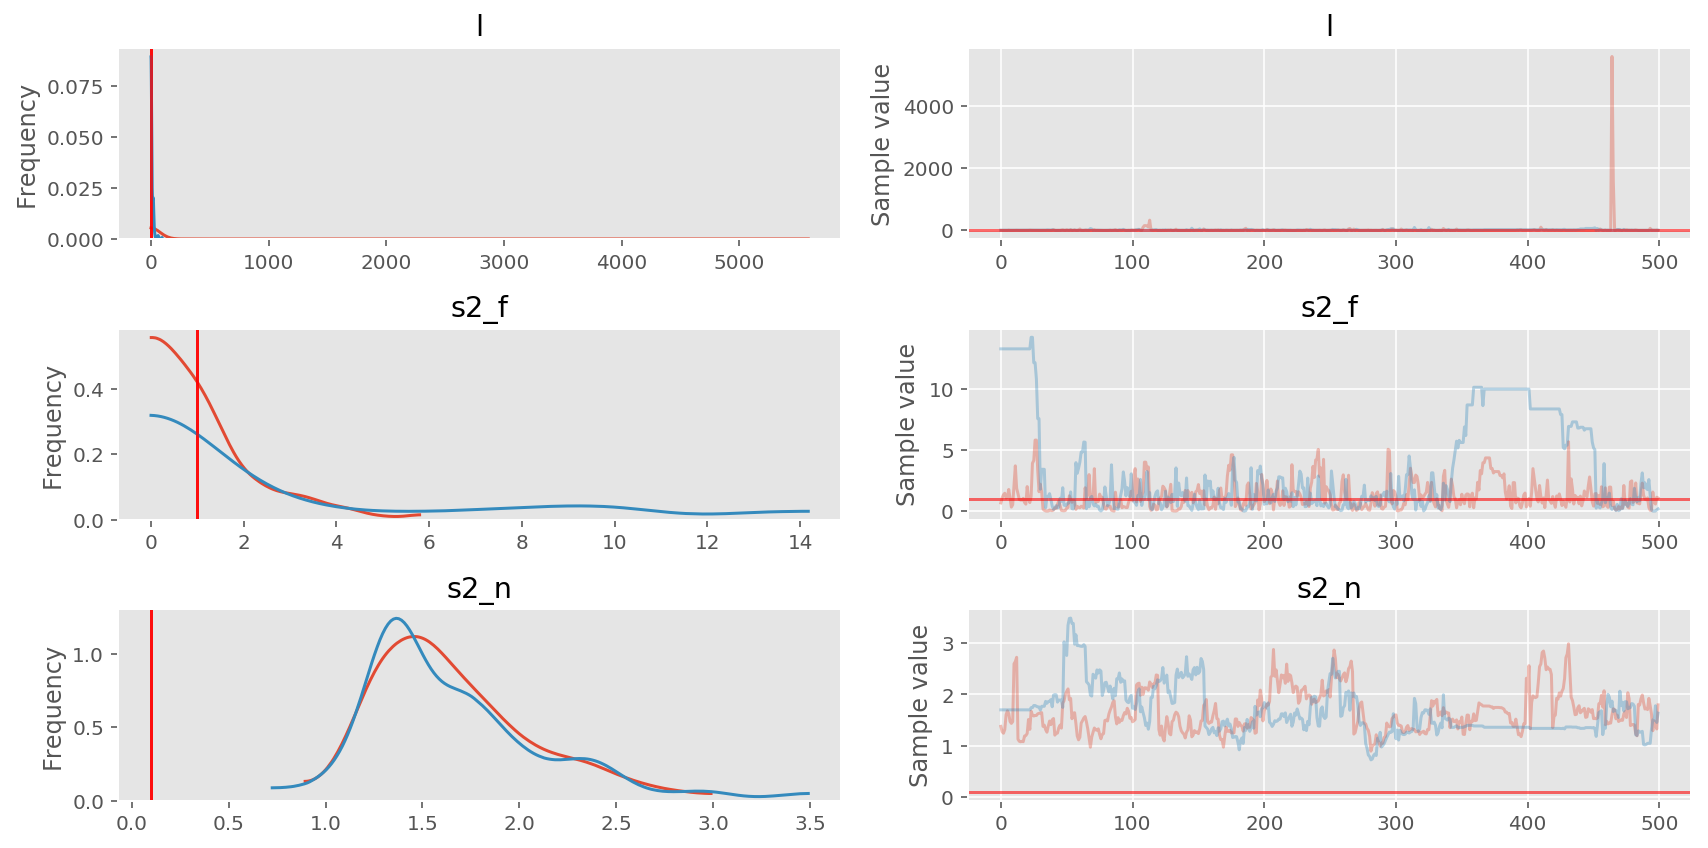

In [70]:
temp_trace = trace[1500:]

pm.traceplot(temp_trace, varnames=['l', 's2_f', 's2_n'],
             lines={"l": l_true,
                    "s2_f": s2_f_true,
                    "s2_n": s2_n_true});

/usr/local/lib/python3.5/dist-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


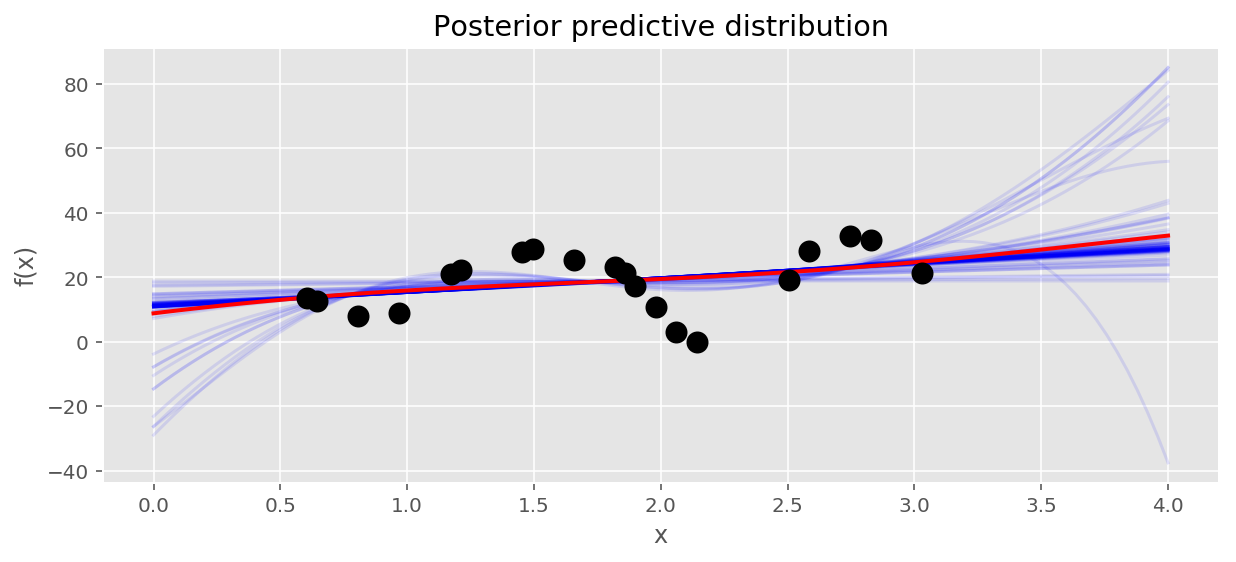

In [38]:
nsample = 100
X_values = {'X':X, 'Y':ymu1, 'Z':Z}
with model:
    gp_samples = sample_gp(temp_trace, f_cov, s2_n, X_values, obs_noise=True, model=model_ng,
                           samples=nsample, progressbar=None)
#     gp_samples = pm.gp.sample_gp(temp_trace, y_obs, Z, 
#                                  samples=nsample, progressbar=None)

_, ax = plt.subplots(figsize=(10,4))

[ax.plot(Z, x, color='b', alpha=0.1) for x in gp_samples]
meanline = np.mean(gp_samples, 0)
line, = ax.plot(Z.squeeze(), meanline,color='r', lw=2)

# overlay the observed data
ax.plot(X, ymu1, 'ok', ms=10);
ax.set_xlabel("x");
ax.set_ylabel("f(x)");
ax.set_title("Posterior predictive distribution");

# References and other useful resource


### Theory  

* Rasmussen, C. E. and Williams, C. K. I. (2006). [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/).
MIT Press. 238, 245  
  

### Intuition  

* [Gaussian Process Models in Python](http://nbviewer.jupyter.org/github/fonnesbeck/gp_showdown/blob/master/GP%20Showdown.ipynb) by Chris Fonnesbeck  
* [Video Lecture](http://videolectures.net/mlss07_rasmussen_bigp/) by Carl Rasmussen  
* Link between Deep neural network and Gaussian Process, [Blog post](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) by  Yarin Gal

  
### Practical  

* [GPML](http://www.gaussianprocess.org/gpml/code/matlab/doc/)  
* Using [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html)  
* GP in Stan see [Manual Chapter 17](https://github.com/stan-dev/stan/releases/download/v2.14.0/stan-reference-2.14.0.pdf) and [Stan example](https://github.com/stan-dev/example-models/tree/master/misc/gaussian-process). Also some information on [Prior choice](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#priors-for-gaussian-processes)   
* [GPy](https://github.com/sheffieldml/gpy) from Sheffield machine learning group  
* [GPflow](https://github.com/GPflow/GPflow)  
* [PyMC3 GP module](http://pymc-devs.github.io/pymc3/examples.html#gaussian-processes)  